In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.precision', 2)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


### Load Python Pakages

In [2]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import time
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.base import clone

import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer, quantile_transform

#statistics
from scipy.stats import randint, mode

#feature engineering
from sklearn.feature_selection import mutual_info_classif

#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn import set_config

#feature engineering
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFECV

#algorithms
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.linear_model import LogisticRegression

#model evaluation
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, log_loss, auc, accuracy_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error, make_scorer, RocCurveDisplay, confusion_matrix

#model evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, confusion_matrix, matthews_corrcoef, make_scorer

# Optuna and visualization tools
import optuna
USE_OPTUNA = False
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

from matplotlib.colors import LinearSegmentedColormap

random_state = 42

In [3]:
#!python /kaggle/usr/lib/lgbm_cat/lgbm_cat.py 

### Lets look into data

### Check for missing values

In [4]:
# Read the data
sample_sub = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
train_df = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv', index_col=[0])
test_df = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv', index_col=[0])
#Original = pd.read_csv('/kaggle/input/used-car-price-prediction-dataset/used_cars.csv')

#Original[['milage', 'price']] = Original[['milage', 'price']].map(
#    lambda x: int(''.join(re.findall(r'\d+', x))))

#train = pd.concat([train, Original], ignore_index=True)

#train_df.head()

In [5]:
train_df.isna().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [6]:
test_df.isna().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

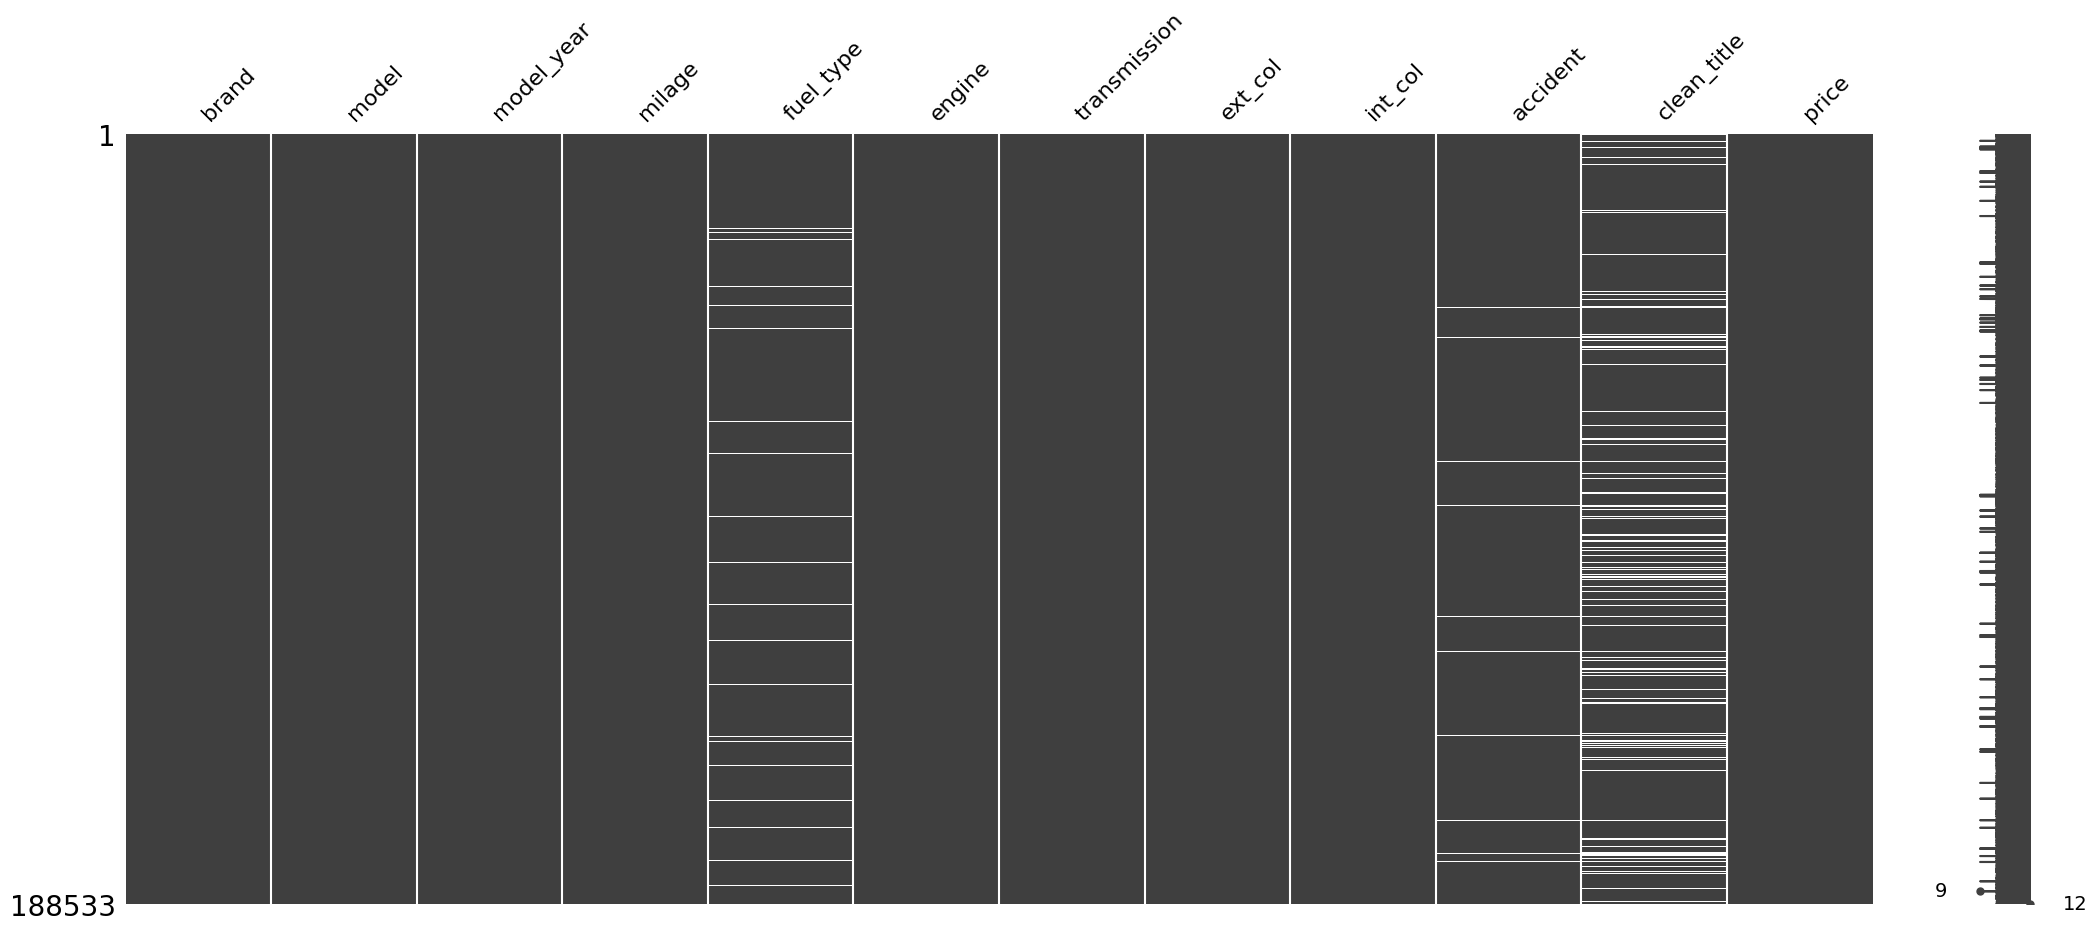

In [7]:
%matplotlib inline
msno.matrix(train_df)
plt.show()

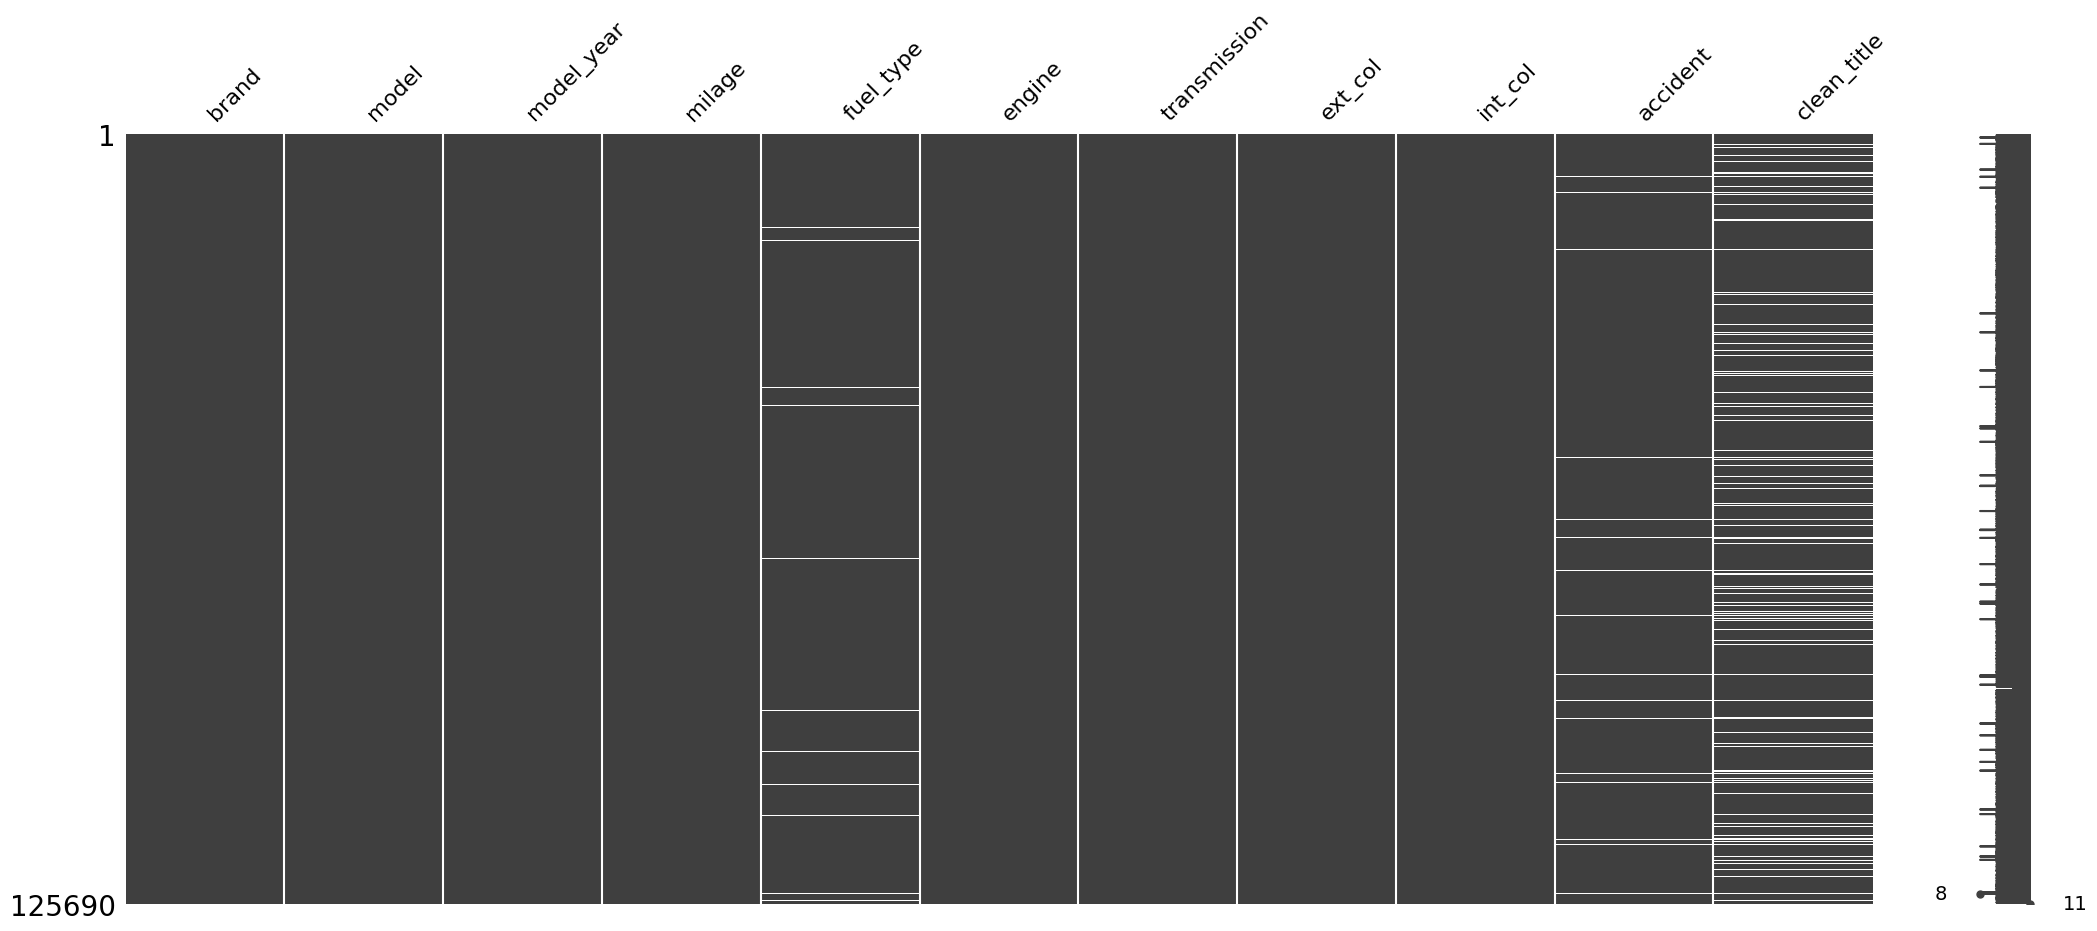

In [8]:
%matplotlib inline
msno.matrix(test_df)
plt.show()

In [9]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["missing_percent"] = missing[0:] / len(train_df)*100
missing.style.background_gradient('viridis')

,missing_count,missing_percent
clean_title,21419,11.360876
fuel_type,5083,2.696080
accident,2452,1.300568


In [10]:
missing = pd.DataFrame(test_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["missing_percent"] = missing[0:] / len(test_df)*100
missing.style.background_gradient('viridis')

,missing_count,missing_percent
clean_title,14239,11.328666
fuel_type,3383,2.691543
accident,1632,1.298433


### Descriptive statistics

In [11]:
#numerical feature descriptive statistics

train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
model_year,188533.0,2015.83,5.66,1974.0,2013.0,2017.0,2020.0,2.02e+03
milage,188533.0,65705.30,49798.16,100.0,24115.0,57785.0,95400.0,4.05e+05
price,188533.0,43878.02,78819.52,2000.0,17000.0,30825.0,49900.0,2.95e+06


### Grouping features for preprocessing purposes

In [12]:
train_df.nunique().sort_values()

clean_title        1
accident           2
fuel_type          7
model_year        34
transmission      52
brand             57
int_col          156
ext_col          319
engine          1117
price           1569
model           1897
milage          6651
dtype: int64

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 18.7+ MB


### Feature Types

In [14]:
cat_fea = train_df.select_dtypes(include='object').columns.tolist()

num_fea = train_df.select_dtypes(exclude='object').columns.tolist()

for feature in ['price', 'id']:
    if feature in num_fea:
        num_fea.remove(feature)

# Create DataFrames for continuous and categorical variables

df_numerical = pd.DataFrame({'Numerical Variables': num_fea})
df_categorical = pd.DataFrame({'Categorical Variables': cat_fea})

print(df_numerical)
print(df_categorical)

  Numerical Variables
0          model_year
1              milage
  Categorical Variables
0                 brand
1                 model
2             fuel_type
3                engine
4          transmission
5               ext_col
6               int_col
7              accident
8           clean_title


In [15]:
#cat_features = test_df.select_dtypes('object').columns
# Reference: https://www.kaggle.com/code/ambrosm/pss4e8-eda-which-makes-sense
#for feature in cat_features:          
#    categories = sorted(list(set(train_df[feature].dropna())))
#    dtype = pd.CategoricalDtype(categories=categories, ordered=False)
    
#    train_df.loc[~train_df[feature].isin(categories), feature] = np.nan
#    test_df.loc[~test_df[feature].isin(categories), feature] = np.nan
    
#    train_df[feature] = train_df[feature].astype(dtype)
#    test_df[feature] = test_df[feature].astype(dtype)

### Exploratory Data Analysis¶

In [16]:
def extract_age_features(df, current_year=2024):

    df['Vehicle_Age'] = (current_year - df['model_year']) + 1
    
    df['Mileage_per_Year'] = df['milage'] / df['Vehicle_Age']
        
    df['milage_with_age'] =  df.groupby('Vehicle_Age')['milage'].transform('mean')
    
    df['Mileage_per_Year_with_age'] =  df.groupby('Vehicle_Age')['Mileage_per_Year'].transform('mean')
 
#     df['milage_brand'] =  df.groupby('brand')['milage'].transform('mean')
    
    
    return df

In [17]:
def extract_engine_features(df):
    
    def extract_horsepower(engine):
        try:
            return float(engine.split('HP')[0])
        except:
            return None

    def extract_engine_size(engine):
        try:
            return float(engine.split(' ')[1].replace('L', ''))
        except:
            return None

    df['Horsepower'] = df['engine'].apply(extract_horsepower)
    df['Engine_Size'] = df['engine'].apply(extract_engine_size)
    df['Power_to_Weight_Ratio'] = df['Horsepower'] / df['Engine_Size']
    
    return df

In [18]:
def extract_other_features(df):
    
    luxury_brands =  ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Land', 
                    'Lexus', 'Jaguar', 'Bentley', 'Maserati', 'Lamborghini', 
                    'Rolls-Royce', 'Ferrari', 'McLaren', 'Aston', 'Maybach']
    df['Is_Luxury_Brand'] = df['brand'].apply(lambda x: 'Yes' if x in luxury_brands else 'No')
    
#    df['luxary_with_accident'] = df.apply(lambda row: 1 if row['Is_Luxury_Brand'] == 1  and row['accident'] == 'At least 1 accident or damage reported' else 0  ,  axis =1)
    
#     df.drop(columns = ['Is_Luxury_Brand'] , inplace=True)

    return df

In [19]:
def transform_other_features(df):
    
    df['accident'] = df['accident'].apply(lambda x: 'No' if x == 'None reported' else 'Yes')

    return df

In [20]:
%%time

train_df = extract_age_features(train_df)
test_df = extract_age_features(test_df)

# train = extract_engine_features(train)
# test = extract_engine_features(test)

train_df = extract_other_features(train_df)
test_df = extract_other_features(test_df)

train_df = transform_other_features(train_df)
test_df = transform_other_features(test_df)

CPU times: user 233 ms, sys: 0 ns, total: 233 ms
Wall time: 233 ms


In [21]:
def update(df, threshold=100):
    
    corrected_category_features = ['model', 'engine', 'transmission', 'ext_col', 'int_col']
    
    for col in corrected_category_features:
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < threshold, col] = "noise"
    
    for col in corrected_category_features:
        df[col] = df[col].fillna('missing')
        df[col] = df[col].astype('category')
        
    return df

In [22]:
train_df  = update(train_df)
test_df   = update(test_df)

In [23]:
# Store numerical and categorical features to different lists for visualization purposes
feature_list = [feature for feature in train_df.columns if not feature == 'price']

target = "price"

#from data set description

binary_features = ['clean_title', 'accident', 'Is_Luxury_Brand']

categorical_features = ['brand','model','fuel_type','engine','transmission',
                        'ext_col','int_col']

train_df[binary_features] = train_df[binary_features].astype('category')
test_df[binary_features] = test_df[binary_features].astype('category')

train_df[categorical_features] = train_df[categorical_features].astype('category')
test_df[categorical_features] = test_df[categorical_features].astype('category')

continuous_features = list(set(feature_list) - set(binary_features)- set(categorical_features))
assert feature_list.sort() == (continuous_features + binary_features + categorical_features).sort()


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   brand                      188533 non-null  category
 1   model                      188533 non-null  category
 2   model_year                 188533 non-null  int64   
 3   milage                     188533 non-null  int64   
 4   fuel_type                  183450 non-null  category
 5   engine                     188533 non-null  category
 6   transmission               188533 non-null  category
 7   ext_col                    188533 non-null  category
 8   int_col                    188533 non-null  category
 9   accident                   188533 non-null  category
 10  clean_title                167114 non-null  category
 11  price                      188533 non-null  int64   
 12  Vehicle_Age                188533 non-null  int64   
 13  Mileage_per_Year   

In [25]:
train_df.nunique().sort_values()

clean_title                      1
accident                         2
Is_Luxury_Brand                  2
fuel_type                        7
transmission                    31
Vehicle_Age                     34
model_year                      34
int_col                         34
milage_with_age                 34
Mileage_per_Year_with_age       34
brand                           57
ext_col                         61
engine                         407
model                          481
price                         1569
milage                        6651
Mileage_per_Year             30368
dtype: int64

In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125690 entries, 188533 to 314222
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   brand                      125690 non-null  category
 1   model                      125690 non-null  category
 2   model_year                 125690 non-null  int64   
 3   milage                     125690 non-null  int64   
 4   fuel_type                  122307 non-null  category
 5   engine                     125690 non-null  category
 6   transmission               125690 non-null  category
 7   ext_col                    125690 non-null  category
 8   int_col                    125690 non-null  category
 9   accident                   125690 non-null  category
 10  clean_title                111451 non-null  category
 11  Vehicle_Age                125690 non-null  int64   
 12  Mileage_per_Year           125690 non-null  float64 
 13  milage_with_ag

In [27]:
test_df.nunique().sort_values()

clean_title                      1
accident                         2
Is_Luxury_Brand                  2
fuel_type                        7
int_col                         27
transmission                    29
model_year                      36
Vehicle_Age                     36
Mileage_per_Year_with_age       36
milage_with_age                 36
ext_col                         44
brand                           55
engine                         297
model                          323
milage                        5700
Mileage_per_Year             25615
dtype: int64

### Exploratory Data Analysis

In [28]:
print(continuous_features)

['model_year', 'milage_with_age', 'Mileage_per_Year', 'Mileage_per_Year_with_age', 'Vehicle_Age', 'milage']


In [29]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
model_year,188533.0,2015.83,5.66,1974.00,2013.00,2017.00,2020.00,2.02e+03
milage,188533.0,65705.30,49798.16,100.00,24115.00,57785.00,95400.00,4.05e+05
price,188533.0,43878.02,78819.52,2000.00,17000.00,30825.00,49900.00,2.95e+06
Vehicle_Age,188533.0,9.17,5.66,1.00,5.00,8.00,12.00,5.10e+01
Mileage_per_Year,188533.0,7226.68,4609.22,5.00,4280.80,6857.14,9445.83,1.18e+05
milage_with_age,188533.0,65705.30,35500.59,9773.01,34423.87,67940.69,92865.34,1.34e+05
Mileage_per_Year_with_age,188533.0,7226.68,1052.22,1326.56,6769.56,7389.73,7975.32,1.46e+04


In [30]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
model_year,125690.0,2015.80,5.67,1974.00,2013.00,2017.00,2020.00,2024.00
milage,125690.0,66042.58,50223.86,100.00,24500.00,57500.00,95798.00,405000.00
Vehicle_Age,125690.0,9.20,5.67,1.00,5.00,8.00,12.00,51.00
Mileage_per_Year,125690.0,7226.45,4640.49,2.25,4291.67,6850.90,9450.00,99875.00
milage_with_age,125690.0,66042.58,35865.22,2442.00,34258.89,68130.89,93031.57,179400.00
Mileage_per_Year_with_age,125690.0,7226.45,1026.77,66.00,6704.20,7443.65,8041.66,14980.07


In [31]:
#Data is huge just take some sample for eda
#eda_df = train_df.sample(frac=0.01)
#sub_df = test_df.sample(frac=0.01)

In [32]:
#fig, ax = plt.subplots(2, 3, figsize=(60, 40))
#for var, subplot in zip(continuous_features, ax.flatten()):
#    sns.boxplot(x=var, y='price', data=eda_df, ax=subplot, hue = 'price')

### Feature Engineering

In [33]:
con_fe_df = train_df[continuous_features + ['price']]

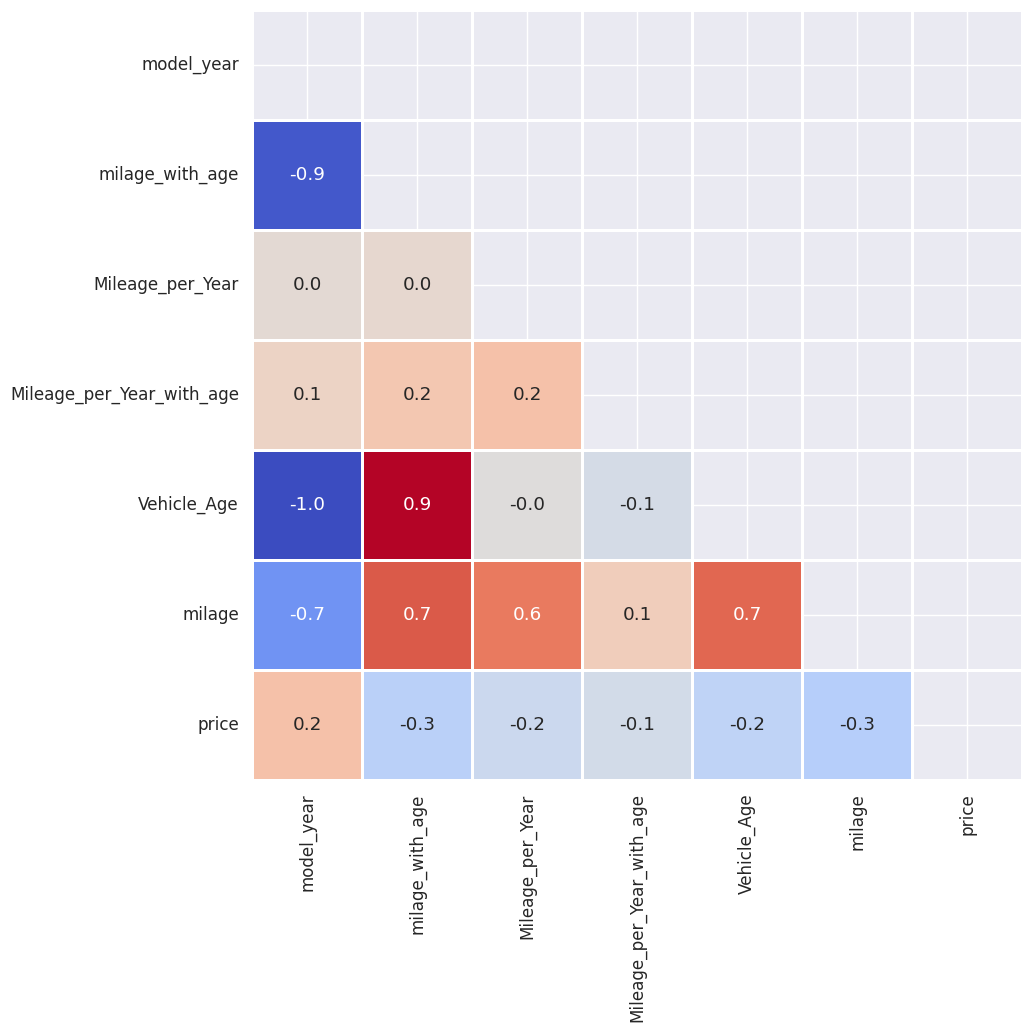

In [34]:
# Display correlations between numerical features and saleprice on heatmap.

sns.set(font_scale=1.1)
correlation_train = con_fe_df.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

In [35]:
# mutual information for numerical features
#You need to fillna to get results from mutual_info_regression function
mutual_df = train_df[continuous_features]

mutual_info = mutual_info_regression(mutual_df.fillna(0), train_df['price'], random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] ).style.background_gradient("cool")

,Numerical_Feature_MI
milage,0.660683
Vehicle_Age,0.543923
Mileage_per_Year_with_age,0.542625
model_year,0.541914
milage_with_age,0.539792
Mileage_per_Year,0.232034


In [36]:
#fig, ax = plt.subplots(2, 4, figsize=(80, 40))
#for var, subplot in zip(categorical_features, ax.flatten()):    
#    sns.boxplot(x=var, y='price', data=train_df, ax=subplot, palette='Set3')
#    for ax in fig.axes:
#        plt.sca(ax)
#        plt.xticks(rotation=60)

In [37]:
#categorical features must be encoded to get mutual information
mutual_df_categorical = train_df[categorical_features]

for colname in mutual_df_categorical:
    mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()
mutual_info = mutual_info_regression(mutual_df_categorical.fillna("Missing"), train_df['price'], random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_categorical.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Categorical_Feature_MI"] ).style.background_gradient("cool")

,Categorical_Feature_MI
transmission,0.153008
int_col,0.075144
ext_col,0.058733
brand,0.032581
fuel_type,0.031742
engine,0.014878
model,0.006238


In [38]:
callbacks = [log_evaluation(period=300), early_stopping(stopping_rounds=200)]

cat_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"cat_cols--------{cat_cols}")

cat_cols--------['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'Is_Luxury_Brand']


In [39]:
labelencoder = LabelEncoder()

# Initialize LabelEncoder
label_encoders = {col: LabelEncoder() for col in cat_cols}

for col in cat_cols:
    train_df[col] = label_encoders[col].fit_transform(train_df[col])
    train_df[col] = train_df[col].astype('int32')
    test_df[col] = label_encoders[col].transform(test_df[col])
    test_df[col] = test_df[col].astype('int32')

### Scaling data

In [40]:
scaler = StandardScaler()
train_df[continuous_features] = scaler.fit_transform(train_df[continuous_features])
test_df[continuous_features] = scaler.transform(test_df[continuous_features])

### Define the bounds for outliers:

Q1 = train_data['price'].quantile(0.25) 

Q3 = train_data['price'].quantile(0.75) 

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 IQR 

upper_bound = Q3 + 1.5 IQR

train_data['price'] = np.where(train_data['price'] > upper_bound, upper_bound, np.where(train_data['price'] < lower_bound, lower_bound, train_data['price']))

### Statistical Methods:

Z-Score Method: Remove or cap outliers based on the Z-score, which measures how many standard deviations an element is from the mean.

### Calculate Z-scores

z_scores = np.abs((train_data['price'] - train_data['price'].mean()) / train_data['price'].std())

### Set a threshold for what constitutes an outlier (commonly 3 standard deviations)

threshold = 3

### Remove outliers

train_data = train_data[z_scores < threshold]

In [41]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
brand,188533.0,2.32e+01,15.87,0.00,9.00,21.00,36.00,5.60e+01
model,188533.0,2.97e+02,159.28,0.00,160.00,303.00,480.00,4.80e+02
model_year,188533.0,1.87e-14,1.00,-7.39,-0.50,0.21,0.74,1.44e+00
milage,188533.0,8.15e-17,1.00,-1.32,-0.84,-0.16,0.60,6.81e+00
fuel_type,188533.0,2.12e+00,0.94,0.00,2.00,2.00,2.00,7.00e+00
engine,188533.0,2.34e+02,120.96,0.00,135.00,246.00,338.00,4.06e+02
transmission,188533.0,1.76e+01,8.04,0.00,11.00,19.00,23.00,3.00e+01
ext_col,188533.0,3.17e+01,21.39,0.00,5.00,30.00,56.00,6.00e+01
int_col,188533.0,6.10e+00,9.49,0.00,1.00,1.00,10.00,3.30e+01
accident,188533.0,2.33e-01,0.42,0.00,0.00,0.00,0.00,1.00e+00


In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   brand                      188533 non-null  int32  
 1   model                      188533 non-null  int32  
 2   model_year                 188533 non-null  float64
 3   milage                     188533 non-null  float64
 4   fuel_type                  188533 non-null  int32  
 5   engine                     188533 non-null  int32  
 6   transmission               188533 non-null  int32  
 7   ext_col                    188533 non-null  int32  
 8   int_col                    188533 non-null  int32  
 9   accident                   188533 non-null  int32  
 10  clean_title                188533 non-null  int32  
 11  price                      188533 non-null  int64  
 12  Vehicle_Age                188533 non-null  float64
 13  Mileage_per_Year           188533 

In [43]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
brand,125690.0,2.32e+01,15.91,0.00,9.00,21.00,36.00,55.00
model,125690.0,3.21e+02,161.24,1.00,187.00,360.00,480.00,480.00
model_year,125690.0,-5.74e-03,1.00,-7.39,-0.50,0.21,0.74,1.44
milage,125690.0,6.77e-03,1.01,-1.32,-0.83,-0.16,0.60,6.81
fuel_type,125690.0,2.12e+00,0.94,0.00,2.00,2.00,2.00,7.00
engine,125690.0,2.49e+02,123.82,6.00,147.00,255.00,368.00,406.00
transmission,125690.0,1.76e+01,8.05,0.00,11.00,19.00,23.00,30.00
ext_col,125690.0,3.21e+01,21.50,0.00,5.00,30.00,56.00,60.00
int_col,125690.0,6.16e+00,9.59,0.00,1.00,1.00,10.00,33.00
accident,125690.0,2.34e-01,0.42,0.00,0.00,0.00,0.00,1.00


In [44]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125690 entries, 188533 to 314222
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   brand                      125690 non-null  int32  
 1   model                      125690 non-null  int32  
 2   model_year                 125690 non-null  float64
 3   milage                     125690 non-null  float64
 4   fuel_type                  125690 non-null  int32  
 5   engine                     125690 non-null  int32  
 6   transmission               125690 non-null  int32  
 7   ext_col                    125690 non-null  int32  
 8   int_col                    125690 non-null  int32  
 9   accident                   125690 non-null  int32  
 10  clean_title                125690 non-null  int32  
 11  Vehicle_Age                125690 non-null  float64
 12  Mileage_per_Year           125690 non-null  float64
 13  milage_with_age            12

### XBoost

#### Performing different kind of feature engineering here because while XGBoost handles null and categorical data well, CatBoost and LightGBM may encounter performance issues and have specific requirements.

In [45]:
X_train = train_df.drop(columns=["price"])
y_train = train_df["price"]

X_test = test_df
#X_test = test_df.drop(columns=["id"])

In [46]:
#I have used 5 splits here.
def cross_validate_model_x(model, X_train, y_train, params, n_splits=5):

    # Initialize variables
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_scores = []
    test_preds = np.zeros((len(X_test), n_splits), dtype=np.float32)
    # Cross-validation loop
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X_train)):
        # Data splitting
        X_fold_train = X_train.iloc[train_ind]
        y_fold_train = y_train.iloc[train_ind]
        X_val = X_train.iloc[valid_ind]
        y_val = y_train.iloc[valid_ind]
        
        # Model initialization and training
        clf = model(**params, enable_categorical=True)
        #clf.fit(X_fold_train, y_fold_train)
        clf.fit(X_fold_train, y_fold_train,  eval_set=[(X_val, y_val)],verbose=500, early_stopping_rounds=50)
        # Predict and evaluate
        test_preds[:, fold] = clf.predict(X_test)

        print("-" * 50)
        print(test_preds)

    test_preds= np.mean(test_preds, axis=1)
    return clf,test_preds

In [47]:
xgb_params={
    
'lambda': 0.17694956261235095,
 'alpha': 1.3889763984339085,
 'colsample_bytree': 0.7,
 'subsample': 1.0,
 'learning_rate': 0.008,
 'max_depth': 17,
 'random_state': 2020,
 'min_child_weight': 59,
 'n_estimators': 10000,
 'tree_method': 'gpu_hist'
 
}

print('XGBoost Cross-Validation Results:\n')
xgb_model, test_predsx = cross_validate_model_x(XGBRegressor, X_train, y_train, xgb_params)

XGBoost Cross-Validation Results:

[0]	validation_0-rmse:74475.92756
[477]	validation_0-rmse:68005.84403
--------------------------------------------------
[[19264.916     0.        0.        0.        0.   ]
 [82759.62      0.        0.        0.        0.   ]
 [59465.06      0.        0.        0.        0.   ]
 ...
 [22784.7       0.        0.        0.        0.   ]
 [14686.59      0.        0.        0.        0.   ]
 [35190.81      0.        0.        0.        0.   ]]
[0]	validation_0-rmse:74776.25571
[346]	validation_0-rmse:68860.79316
--------------------------------------------------
[[19264.916 20398.303     0.        0.        0.   ]
 [82759.62  84388.05      0.        0.        0.   ]
 [59465.06  53708.496     0.        0.        0.   ]
 ...
 [22784.7   23360.84      0.        0.        0.   ]
 [14686.59  17720.566     0.        0.        0.   ]
 [35190.81  35964.344     0.        0.        0.   ]]
[0]	validation_0-rmse:79530.85208
[347]	validation_0-rmse:74001.70400
-----

In [48]:
xgb_result =  pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
xgb_result['price'] = test_predsx.astype(np.float32)
xgb_result

,id,price
0,188533,19941.96
1,188534,83246.95
2,188535,57876.20
3,188536,27770.48
4,188537,32229.14
...,...,...
125685,314218,25159.38
125686,314219,52296.62
125687,314220,21956.41
125688,314221,17161.38


### LGBM

In [49]:
def cross_validate_model_l(model, X_train, y_train, params, n_splits=10):

    # Initialize variables
    callbacks = [log_evaluation(period=150), early_stopping(stopping_rounds=200)]
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_scores = []
    test_preds = np.zeros((len(X_test), n_splits), dtype=np.float32)
    # Cross-validation loop
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X_train)):
        # Data splitting
        X_fold_train = X_train.iloc[train_ind]
        y_fold_train = y_train.iloc[train_ind]
        X_val = X_train.iloc[valid_ind]
        y_val = y_train.iloc[valid_ind]
        
        # Model initialization and training
        clf = model(**params)
        #clf.fit(X_fold_train, y_fold_train)
        clf.fit(X_fold_train, y_fold_train, eval_set=[(X_val, y_val)], callbacks=callbacks )
        # Predict and evaluate
        test_preds[:, fold] = clf.predict(X_test)

        print("-" * 50)
        print(test_preds)

    test_preds= np.mean(test_preds, axis=1)
    return clf,test_preds

In [50]:
# params are taken from this notebook: https://www.kaggle.com/code/noodl35/optuna-lgbm-tuning-used-cars
lgb_params = {
                'num_leaves': 426,
                 'max_depth': 20,
                 'learning_rate': 0.011353178352988012,
                 'n_estimators': 10000,
                 'metric': 'rmse',
                 'subsample': 0.5772552201954328,
                 'colsample_bytree': 0.9164865430101521,
                 'reg_alpha': 1.48699088003429e-06,
                 'reg_lambda': 0.41539458543414265,
                 'min_data_in_leaf': 73,
                 'feature_fraction': 0.751673655170548,
                 'bagging_fraction': 0.5120415391590843,
                 'bagging_freq': 2,
                 'random_state': 42,
                 'min_child_weight': 0.017236362383443497,
                 'cat_smooth': 54.81317407769262,
                 'verbose' : -1             # Set to -1 for silent mode, no process information printed
}

print('LightGBM Cross-Validation Results:\n')
lgb_model,test_predsl = cross_validate_model_l(LGBMRegressor, X_train, y_train, lgb_params)

LightGBM Cross-Validation Results:

Training until validation scores don't improve for 200 rounds
[150]	valid_0's rmse: 69534.7
[300]	valid_0's rmse: 69174.3
[450]	valid_0's rmse: 69181.6
Early stopping, best iteration is:
[348]	valid_0's rmse: 69149.2
--------------------------------------------------
[[18089.658     0.        0.    ...     0.        0.        0.   ]
 [77858.336     0.        0.    ...     0.        0.        0.   ]
 [62382.203     0.        0.    ...     0.        0.        0.   ]
 ...
 [22463.498     0.        0.    ...     0.        0.        0.   ]
 [16297.18      0.        0.    ...     0.        0.        0.   ]
 [35598.82      0.        0.    ...     0.        0.        0.   ]]
Training until validation scores don't improve for 200 rounds
[150]	valid_0's rmse: 67079.1
[300]	valid_0's rmse: 66763.3
[450]	valid_0's rmse: 66828
Early stopping, best iteration is:
[324]	valid_0's rmse: 66758
--------------------------------------------------
[[18089.658 17965.26    

In [51]:
lgb_result =  pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
lgb_result['price'] = test_predsl.astype(np.float32)
lgb_result

,id,price
0,188533,18473.53
1,188534,81684.63
2,188535,58637.09
3,188536,25083.60
4,188537,31456.05
...,...,...
125685,314218,25354.68
125686,314219,50049.54
125687,314220,21933.18
125688,314221,16761.26


### CatBoost

In [52]:
#I have used 5 splits here.
def cross_validate_model_c(model, X_train, y_train, params, n_splits=10):

    # Initialize variables
    
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    val_scores = []
    test_preds = np.zeros((len(X_test), n_splits), dtype=np.float32)
    # Cross-validation loop
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X_train)):
        # Data splitting
        X_fold_train = X_train.iloc[train_ind]
        y_fold_train = y_train.iloc[train_ind]
        X_val = X_train.iloc[valid_ind]
        y_val = y_train.iloc[valid_ind]
        
        # Model initialization and training
        clf = model(**params)
        #clf.fit(X_fold_train, y_fold_train)
        clf.fit(X_fold_train, y_fold_train, eval_set=[(X_val, y_val)], verbose=0)
        # Predict and evaluate
        test_preds[:, fold] = clf.predict(X_test)

        print("-" * 50)
        print(test_preds)

    test_preds= np.mean(test_preds, axis=1)
    return clf,test_preds

In [53]:
cat_params = {
    'cat_features':cat_cols,  
    'learning_rate': 0.075,
    'iterations': 5000,
    'depth': 9,
    'random_strength': 0,
    'l2_leaf_reg': 0.5,
    'task_type': 'GPU',
    'max_leaves': 512,
    'fold_permutation_block': 64,
    'random_seed': 42,
    'verbose': False                      
}

print('CatBoost Cross-Validation Results:\n')
cat_model, test_predsc = cross_validate_model_c(CatBoostRegressor, X_train, y_train, cat_params)

CatBoost Cross-Validation Results:

--------------------------------------------------
[[17655.57      0.        0.    ...     0.        0.        0.   ]
 [78135.86      0.        0.    ...     0.        0.        0.   ]
 [53800.93      0.        0.    ...     0.        0.        0.   ]
 ...
 [20133.371     0.        0.    ...     0.        0.        0.   ]
 [15191.497     0.        0.    ...     0.        0.        0.   ]
 [35390.7       0.        0.    ...     0.        0.        0.   ]]
--------------------------------------------------
[[17655.57  17901.05      0.    ...     0.        0.        0.   ]
 [78135.86  81606.15      0.    ...     0.        0.        0.   ]
 [53800.93  59151.73      0.    ...     0.        0.        0.   ]
 ...
 [20133.371 21639.055     0.    ...     0.        0.        0.   ]
 [15191.497 16197.876     0.    ...     0.        0.        0.   ]
 [35390.7   34950.387     0.    ...     0.        0.        0.   ]]
----------------------------------------------

In [54]:
cat_result =  pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
cat_result['price'] = test_predsc.astype(np.float32)
cat_result

,id,price
0,188533,18024.84
1,188534,82524.36
2,188535,56925.95
3,188536,28418.73
4,188537,32598.24
...,...,...
125685,314218,29142.18
125686,314219,57520.12
125687,314220,21428.49
125688,314221,16801.10


### Building a Prediction Ensemble

In [55]:
Pred = pd.concat([lgb_result,cat_result,xgb_result], axis=1)['price']
print(Pred)
test_preds = test_predsl * 0.7 + test_predsc * 0.1 + test_predsx*0.2

           price     price     price
0       18473.53  18024.84  19941.96
1       81684.63  82524.36  83246.95
2       58637.09  56925.95  57876.20
3       25083.60  28418.73  27770.48
4       31456.05  32598.24  32229.14
...          ...       ...       ...
125685  25354.68  29142.18  25159.38
125686  50049.54  57520.12  52296.62
125687  21933.18  21428.49  21956.41
125688  16761.26  16801.10  17161.38
125689  36345.41  34602.21  35250.20

[125690 rows x 3 columns]


In [56]:
ensemble_sub =  pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
ensemble_sub['price'] = test_preds

ensemble_sub.to_csv('submission.csv', index=False)

In [57]:
#def get_MAE_oof(df, target, lgb_params, cat_params=None, model_type='LGBM'):

#    oof_predictions = np.zeros(len(df))
#    kf = KFold(n_splits=5, shuffle=True, random_state=42)
#    models = []
#    rmse_scores = []
    
#    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
#        print(f"Training fold {fold + 1}/{5} with {model_type}")

#        X_train, X_val = df.iloc[train_idx], df.iloc[val_idx]
#        y_train, y_val = target.iloc[train_idx], target.iloc[val_idx]

#        if model_type == 'LGBM':
#            train_data = lgb.Dataset(X_train, label=y_train)
#            val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
            
#            model = lgb.train(
#                lgb_params,
#                train_data,
#                valid_sets=[train_data, val_data],
#                valid_names=['train', 'valid'],
#                callbacks=callbacks    
#            )
        
#        elif model_type == 'CAT':
#            train_data = Pool(data=X_train, label=y_train , cat_features=cat_cols)
#            val_data = Pool(data=X_val, label=y_val , cat_features=cat_cols )
            
#            model = CatBoostRegressor(**cat_params)
#            model.fit(train_data, eval_set=val_data, verbose=150, early_stopping_rounds=200)
        
#        models.append(model)
        
#        if model_type == 'LGBM':
#            pred = model.predict(X_val, num_iteration=model.best_iteration)
#        elif model_type == 'CAT':
#            pred = model.predict(X_val)
        
#        rmse = np.sqrt(mean_squared_error(y_val, pred))
#        rmse_scores.append(rmse)

#        print(f'{model_type} Fold RMSE: {rmse}')
        
#        oof_predictions[val_idx] = pred
        
#    print(f'Mean RMSE: {np.mean(rmse_scores)}')
#    return oof_predictions, models

#lgb_params = {
#    'objective': 'MAE',
#    'n_estimators': 1000,
#    'random_state': 42,
#}

#oof_predictions_lgbm, models_lgbm = get_MAE_oof(X, y, lgb_params, model_type='LGBM')
#X['LGBM_MAE'] = oof_predictions_lgbm

#LGBM_preds = np.zeros(len(test_df))
#for model in models_lgbm:
#    LGBM_preds += model.predict(test_df) / len(models_lgbm)
#test_df['LGBM_MAE'] = LGBM_preds

#lgb_params = {
#    'objective': 'MSE',
#    'n_estimators': 1000,
#    'random_state': 42,
#}

#oof_predictions_lgbm, models_lgbm = get_MAE_oof(X, y, lgb_params, model_type='LGBM')

#X['LGBM_MSE_diff'] = oof_predictions_lgbm - X['LGBM_MAE']

#LGBM_preds = np.zeros(len(test_df))
#for model in models_lgbm:
#    LGBM_preds += model.predict(test_df) / len(models_lgbm)
#test_df['LGBM_MSE_diff'] = LGBM_preds - test_df['LGBM_MAE']

In [58]:
#def objective_lgb(trial):   
#    lgb_params = {
#        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
#        'max_depth': trial.suggest_int('max_depth', 5, 50),
#        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1.0),
#        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 10.0),
#        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#        'subsample': trial.suggest_uniform('subsample', 0.2, 1.0),
#        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.2, 1.0),
#        'n_estimators': 1000,
#        'random_state': 42
#    }

#    kf = KFold(n_splits=5, shuffle=True, random_state=42)
#    rmse_scores = []

#    for train_index, val_index in kf.split(X):
#        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#        train_data = lgb.Dataset(X_train, label=y_train)
#        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

#        model = lgb.train(lgb_params, 
#                          train_data, 
#                          valid_sets=[val_data], 
#                          callbacks=callbacks
#                         )

#        y_pred = model.predict(X_val)
#        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#        rmse_scores.append(rmse)

#    return np.mean(rmse_scores)

#def objective_cat(trial):

#    cat_params = {
#        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
#        'depth': trial.suggest_int('depth', 5, 16),
#        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 10.0),
#        'iterations': 1000,
#        'random_strength': trial.suggest_int('random_strength', 0, 100),
#        'cat_features': cat_cols,
#        'random_seed': 42,
#        'task_type': 'GPU',
#        'early_stopping_rounds': 200
#    }
    
#    kf = KFold(n_splits=5, shuffle=True, random_state=42)
#    rmse_scores_cat = []

#    for train_index, val_index in kf.split(X):
#        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
#        train_pool = Pool(X_train, y_train, cat_features=cat_cols)
#        val_pool = Pool(X_val, y_val, cat_features=cat_cols)
        
#        model_cat = CatBoostRegressor(**cat_params)
#        model_cat.fit(train_pool, eval_set=val_pool, verbose=300)
        
#        y_pred_cat = model_cat.predict(X_val)
#        rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))
#        rmse_scores_cat.append(rmse_cat)
    
#    return np.mean(rmse_scores_cat)

#if USE_OPTUNA==True:
#    study_lgb = optuna.create_study(direction='minimize')
#    study_lgb.optimize(objective_lgb, n_trials=20)

#    print("Best LGBM Parameters: ", study_lgb.best_params)
#    print("Best LGBM RMSE: ", study_lgb.best_value)

#    study_cat = optuna.create_study(direction='minimize')
#    study_cat.optimize(objective_cat, n_trials=2)

#    print("Best CatBoost Parameters: ", study_cat.best_params)
#    print("Best CatBoost RMSE: ", study_cat.best_value)

In [59]:
#lgb_params_1 ={
#    'learning_rate': 0.017521301504983752,
#    'max_depth': 42,
#    'reg_alpha': 0.06876635751774487, 
#    'reg_lambda': 9.738899198284985,
#    'num_leaves': 131,
#    'subsample': 0.2683765421728044,
#    'colsample_bytree': 0.44346036599709887,
#    'n_estimators': 1000,
#    'random_state': 42,
#    'extra_tree' : True,
#    'verbose' : -1
#}

#lgb_params_2 ={
#    'learning_rate': 0.017521301504983752,
#    'max_depth': 42,
#    'reg_alpha': 0.06876635751774487, 
#    'reg_lambda': 9.738899198284985,
#    'num_leaves': 131,
#    'subsample': 0.2683765421728044,
#    'colsample_bytree': 0.44346036599709887,
#    'n_estimators': 1000,
#    'random_state': 42,
#    'verbose' : -1
#}

#cat_params={
#    'learning_rate':0.042,
#    'iterations':1000,
#    'depth':10,
#    'random_strength' : 10,
#    'cat_features':cat_cols,
#    'l2_leaf_reg':0.3,
#    'random_seed':42,
#    'early_stopping_rounds': 200,
#    'task_type':'GPU',
#}

#kf = KFold(n_splits=5, shuffle=True, random_state=42)

#rmse_scores = []
#rmse_scores_cat = []
#LGBM_model=[]
#CAT_model =[]

#callbacks = [log_evaluation(period=150), early_stopping(stopping_rounds=200)]

#for train_index, val_index in kf.split(X):
#    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
#    train_data = lgb.Dataset(X_train, label=y_train)
#    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
#    model_1 = lgb.train(lgb_params_1,
#                      train_data,
#                      valid_sets=[train_data, val_data],
#                      valid_names=['train', 'valid'],
#                      callbacks=callbacks        
#                      )
#    model_2 = lgb.train(lgb_params_2,
#                  train_data,
#                  valid_sets=[train_data, val_data],
#                  valid_names=['train', 'valid'],
#                  callbacks=callbacks        
#                  )
    
#    LGBM_model.append(model_1)
#    LGBM_model.append(model_2)

#    y_pred = model_1.predict(X_val) * 0.5 + model_2.predict(X_val) * 0.5
    
#    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#    rmse_scores.append(rmse)
    
#    print(f'LGBM Fold RMSE: {rmse}')
    
#    model_cat = CatBoostRegressor(**cat_params)
    
#    train_pool = Pool(X_train, y_train ,cat_features=cat_cols)
#    val_pool = Pool(X_val, y_val , cat_features=cat_cols)
#    model_cat.fit(train_pool, eval_set=val_pool, verbose=300)
    
#    CAT_model.append(model_cat)
#    y_pred_cat = model_cat.predict(X_val)
#    rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))
#    rmse_scores_cat.append(rmse_cat)
    
#    print(f'CAT Fold RMSE: {rmse_cat}')

#print(f'Mean LGBM RMSE: {np.mean(rmse_scores)}')
#print(f'Mean CAT RMSE: {np.mean(rmse_scores_cat)}')

In [60]:
#LGBM_preds = np.zeros(len(test_df))
#for model in LGBM_model:
#    LGBM_preds += model.predict(test_df) / len(LGBM_model)

In [61]:
#CAT_preds = np.zeros(len(test_df))
#for model in CAT_model:
#    CAT_preds += model.predict(test_df) / len(CAT_model)

In [62]:
#test_preds = LGBM_preds * 0.8 + CAT_preds * 0.2

In [63]:
#sample_sub['price'] = (0.9 * test_preds + 0.1 * sub_1['price']) * 0.4 + 0.6 * sub_2['price']
#sample_sub['price'] = test_preds
#sample_sub.to_csv("submission.csv", index=False)
#sample_sub.head()